In [21]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#from xgboost import XGBRegressor
import lightgbm as lgbm

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import  ensemble

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [22]:
df_mining = pd.read_csv(os.getcwd()+'/network_sniff/traffic_minage_1811_15.csv', index_col= 0)
df_not_mining = pd.read_csv(os.getcwd()+'/network_sniff/2911_traffic_calme.csv', index_col= 0)

In [23]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining
Moreover we add the direction of the package

In [24]:
df_mining['miner'] = True
df_mining['outbound'] = df_mining['Source'].apply(lambda x : x == '10.29.231.206') #change ip of miner
df_not_mining['miner'] = False
df_not_mining['outbound'] = df_not_mining['Source'].apply(lambda x : x == '10.29.229.98')

Compute time difference between two packages

In [25]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

Compute time and packet size rolling average and std

In [26]:
window = 4

In [27]:
# delta
# Rolling average
df_mining['ra_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['ra_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_delta'] = df_mining.delta.rolling(window=window).std()
df_not_mining['rstd_delta'] = df_not_mining.delta.diff().rolling(window=window).std()

# Lenght
# Rolling average
df_mining['ra_lenght'] = df_mining.Length.rolling(window=window).mean()
df_not_mining['ra_lenght'] = df_not_mining.Length.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_lenght'] = df_mining.Length.rolling(window=window).std()
df_not_mining['rstd_lenght'] = df_not_mining.Length.diff().rolling(window=window).std()


In [28]:
df_ML = pd.concat([df_mining, df_not_mining], ignore_index=True)
df_ML.reset_index(inplace = True, drop = True)
df_ML.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)

In [29]:
df_ML.describe()

,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
count,41272.000000,4.127000e+04,4.126300e+04,41263.000000,41265.000000,41265.000000
mean,753.771613,3.151798e-02,1.453039e-03,0.094193,0.168939,1332.260382
std,1059.517408,6.948798e-01,2.461157e-01,1.090286,282.003832,1201.291351
min,42.000000,-6.600010e-08,-2.729894e+01,0.000000,-1134.000000,0.000000
25%,66.000000,1.103925e-05,-5.942175e-05,0.000248,-20.250000,175.200837
50%,105.000000,1.887860e-04,-4.725001e-08,0.000581,0.000000,1143.095213
75%,1466.000000,4.567025e-04,5.934062e-05,0.005763,21.750000,2364.574098
max,6806.000000,1.092041e+02,2.730102e+01,89.254340,1637.750000,5287.348422


In [30]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'miner', 'outbound', 'delta', 'ra_delta', 'rstd_delta',
       'ra_lenght', 'rstd_lenght'],
      dtype='object')

In [31]:
df_ML.groupby('miner').mean()

,Length,outbound,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
miner,,,,,,,
False,755.204045,0.468117,0.030102,-4.894163e-08,0.091602,-0.005330,1334.872386
True,84.024691,0.543210,0.753654,7.402318e-01,1.411501,86.472222,30.853182


In [32]:
y = df_ML['miner']
X = df_ML.drop('miner', axis = 1)

In [33]:
y.describe

<bound method NDFrame.describe of 4         True
5         True
6         True
7         True
8         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41263, dtype: bool>

In [34]:
y.value_counts()

False    41182
True        81
Name: miner, dtype: int64

# ML Algorithm
## Pycaret

In [35]:
from pycaret.classification import *
import joblib

In [36]:
# Prediction with Data
def predire(loadmodel,datapredit) :
    best = joblib.load(loadmodel)
    predictions = predict_model(best, data=datapredit)
    print(predictions.head())

In [37]:
# Data
df_Auto= pd.concat([X,y],axis=1)
df_Auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41263 entries, 4 to 41271
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Length       41263 non-null  int64  
 1   outbound     41263 non-null  bool   
 2   delta        41263 non-null  float64
 3   ra_delta     41263 non-null  float64
 4   rstd_delta   41263 non-null  float64
 5   ra_lenght    41263 non-null  float64
 6   rstd_lenght  41263 non-null  float64
 7   miner        41263 non-null  bool   
dtypes: bool(2), float64(5), int64(1)
memory usage: 2.3 MB


In [45]:
predire('Pycaret Module',df_Auto)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


   Length  outbound     delta  ra_delta  rstd_delta  ra_lenght  rstd_lenght  \
4      74      True  0.000650  0.000431    0.000501     187.75   169.922286   
5      74     False  0.027318  0.007251    0.013385     183.75   173.148058   
6      66      True  0.000103  0.007018    0.013537      90.75    39.016022   
7     535      True  0.000200  0.007068    0.013503     187.25   231.864005   
8      66     False  0.027170  0.013698    0.015642     185.25   233.197163   

   miner Label   Score  
4   True  True  1.0000  
5   True  True  1.0000  
6   True  True  1.0000  
7   True  True  0.9996  
8   True  True  1.0000  


## build the model

In [39]:

from pycaret.classification import *
clf1 = setup(data = df_Auto, target = 'miner',fold_strategy='kfold',fold=5,use_gpu=True)


,Description,Value
0,session_id,3155
1,Target,miner
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(41263, 8)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [40]:

best = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2260
svm,SVM - Linear Kernel,1.0000,0.0000,0.9818,1.0000,0.9905,0.9905,0.9907,0.0660
knn,K Neighbors Classifier,0.9999,0.9909,0.9494,1.0000,0.9735,0.9735,0.9741,0.5100
ada,Ada Boost Classifier,0.9999,1.0000,0.9766,1.0000,0.9879,0.9879,0.9881,0.6840
et,Extra Trees Classifier,0.9999,1.0000,0.9403,1.0000,0.9689,0.9688,0.9694,0.6540
dt,Decision Tree Classifier,0.9998,0.9863,0.9727,0.9394,0.9552,0.9550,0.9555,0.0560
rf,Random Forest Classifier,0.9997,1.0000,0.8766,1.0000,0.9326,0.9324,0.9353,0.7080
gbc,Gradient Boosting Classifier,0.9996,0.9873,0.9182,0.9106,0.9099,0.9097,0.9119,2.8340
qda,Quadratic Discriminant Analysis,0.9991,0.9896,0.8532,0.7323,0.7595,0.7590,0.7747,0.0580
lightgbm,Light Gradient Boosting Machine,0.9986,0.9572,0.9000,0.7495,0.7923,0.7918,0.8070,0.1320


In [41]:

predictions = predict_model(best, data=df_Auto)
predictions.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Length,outbound,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght,miner,Label,Score
4,74,True,0.000650,0.000431,0.000501,187.75,169.922286,True,True,1.0000
5,74,False,0.027318,0.007251,0.013385,183.75,173.148058,True,True,1.0000
6,66,True,0.000103,0.007018,0.013537,90.75,39.016022,True,True,1.0000
7,535,True,0.000200,0.007068,0.013503,187.25,231.864005,True,True,0.9996
8,66,False,0.027170,0.013698,0.015642,185.25,233.197163,True,True,1.0000


In [42]:

# Save trained model
import joblib
joblib.dump(best, 'Pycaret Module')


['Pycaret Module']

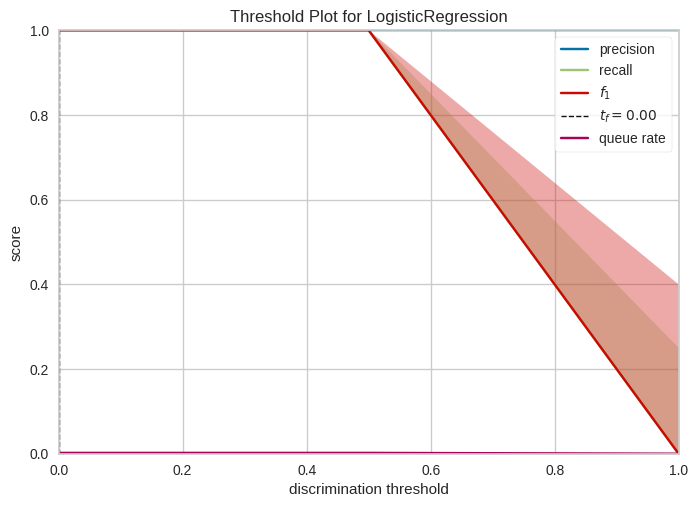

In [51]:
plot_model(best, plot = 'threshold')